# Likelihood XHI 21cmFAST

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc
import logging

In [50]:
import logging
print("Version of py21cmmc: ", p21mc.__version__)

Version of py21cmmc:  1.0.0dev3


In [51]:
pip show 21cmFAST

Name: 21cmFAST
Version: 3.3.1
Summary: A semi-numerical cosmological simulation code for the 21cm signal
Home-page: https://github.com/21cmFAST/21cmFAST
Author: The 21cmFAST coredev team
Author-email: 21cmfast.coredev@gmail.com
License: MIT license
Location: /home/ogarcia/miniconda3/envs/tesis4/lib/python3.9/site-packages
Requires: astropy, bidict, cached-property, cffi, click, h5py, matplotlib, numpy, pyyaml, scipy
Required-by: 21CMMC
Note: you may need to restart the kernel to use updated packages.


In [52]:
# veamos si lo carga por las dudas...
#likelihood = p21mc.LikelihoodNeutralFraction

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from py21cmmc import analyse
from py21cmmc import mcmc
import py21cmmc as p21mc
from scipy.interpolate import InterpolatedUnivariateSpline
import logging

logger = logging.getLogger(__name__)

# desde el 21CMMC
def _ensure_iter(x):
    """Convierte un valor escalar en una lista si no es iterable."""
    try:
        iter(x)
        return x
    except TypeError:
        return [x]

# Def: LikelihoodNeutralFraction ------------------------------------------------------------------------------------------
class LikelihoodNeutralFraction(p21mc.likelihood.LikelihoodBase):
    """
    A likelihood based on the measured neutral fraction at a range of redshifts.

    The log-likelihood statistic is a simple chi^2 if the model has xHI > threshold,
    and 0 otherwise.
    """

    required_cores = (
        (
            p21mc.core.CoreLightConeModule,
            p21mc.core.CoreCoevalModule,
        ),
    )
    threshold = 0.06

    def __init__(self, redshift=5.9, xHI=0.06, xHI_sigma=0.05):
        self.redshift = _ensure_iter(redshift)
        self.xHI = _ensure_iter(xHI)
        self.xHI_sigma = _ensure_iter(xHI_sigma)
        self.redshifts = []
        self._use_coeval = True
        self._require_spline = False

    @property
    def lightcone_modules(self):
        return [m for m in self._cores if isinstance(m, p21mc.core.CoreLightConeModule)]

    @property
    def coeval_modules(self):
        return [
            m for m in self._cores
            if isinstance(m, p21mc.core.CoreCoevalModule)
            and not isinstance(m, p21mc.core.CoreLightConeModule)
        ]

    def setup(self):
        if not (self.lightcone_modules + self.coeval_modules):
            raise ValueError(
                "LikelihoodNeutralFraction needs CoreLightConeModule or CoreCoevalModule."
            )

        if not self.lightcone_modules:
            self.redshifts = list(set(sum((x.redshift for x in self.coeval_modules), [])))
            for z in self.redshift:
                if z not in self.redshifts and len(self.redshifts) < 3:
                    raise ValueError(
                        "Core must be a lightcone or coeval with >=3 redshifts or desired redshift."
                    )
                elif z not in self.redshifts:
                    self._require_spline = True
            self._use_coeval = True
        else:
            self._use_coeval = False
            self._require_spline = True

    def reduce_data(self, ctx):
        err = 0
        if self._use_coeval:
            xHI = np.array([np.mean(x) for x in ctx.get("xHI")])
            redshifts = self.redshifts
        else:
            xHI = ctx.get("lightcone").global_xH  # Cambiado a global_xH por la advertencia
            redshifts = ctx.get("lightcone").node_redshifts
        redshifts, xHI = np.sort([redshifts, xHI])
        return {"xHI": xHI, "redshifts": redshifts, "err": err}

    def computeLikelihood(self, model):
        lnprob = 0

        if self._require_spline:
            model_spline = InterpolatedUnivariateSpline(
                model["redshifts"], model["xHI"], k=1
            )
            if np.sum(model["err"]) > 0:
                err_spline = InterpolatedUnivariateSpline(
                    model["redshifts"], model["err"], k=1
                )

        for z, data, sigma in zip(self.redshift, self.xHI, self.xHI_sigma):
            if np.sum(model["err"]) > 0:
                sigma_t = np.sqrt(sigma**2 + err_spline(z) ** 2)
            else:
                sigma_t = sigma
            
            if z in model["redshifts"]:
                xHI_model = model["xHI"][list(model["redshifts"]).index(z)]
                lnprob += self.lnprob(xHI_model, data, sigma_t)
            elif self._require_spline:
                xHI_model = model_spline(z)
                lnprob += self.lnprob(xHI_model, data, sigma_t)
            else:
                raise ValueError(f"Redshift {z} not found in model redshifts and spline not available.")
        
        logger.debug(f"Neutral fraction Likelihood computed: {lnprob}")
        return lnprob

    def lnprob(self, model, data, sigma):
        model = np.clip(model, 0, 1)
        if model > self.threshold:
            return -0.5 * ((data - model) / sigma) ** 2
        else:
            return 0
#--------------------------------------------------------------------------------------------------------------------------
#  ------------------------------------------------------ PARTE:  CADENAS -------------------------------------------------
#   CoreLightConeModule
core = p21mc.CoreLightConeModule(
    redshift=5.9,
    max_redshift=9.0,
    user_params=dict(
        HII_DIM=50,
        BOX_LEN=125.0,
        N_THREADS= 8,
        
    ),
    z_step_factor=1.04,
    z_heat_max=18.0,
    regenerate=False
)

# AHora el LikelihoodNeutralFraction
likelihood = LikelihoodNeutralFraction(
    redshift=5.9,
    xHI=0.06,
    xHI_sigma=0.05
)

#  MCMC
chain = mcmc.run_mcmc(
    core, likelihood,
    datadir='data',
    model_name="LightconeNeutralFractionTest",
    params=dict(
        L_X_MINI = [40.5, 35.0, 45.0, 3.0],
        F_ESC7_MIN = [-2.22, -3, 0, 0.5],
        F_STAR7_MINI = [-1.75, -3, 0, 0.5], 
        HII_EFF_FACTOR=[30.0, 10.0, 50.0, 3.0],
        ION_Tvir_MIN=[4.7, 4, 6, 0.1],
    ),
    walkersRatio=8,
    burninIterations=0,
    sampleIterations=50,
    threadCount=8,
    continue_sampling=False,
    log_level_stream=logging.DEBUG
)
# --------------------------------------------------------------------------------------------------------------------------
# Análisis
#samples = chain.samples
#analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True)
#analyse.corner_plot(samples)

/home/ogarcia/miniconda3/envs/tesis4/lib/python3.9/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/ogarcia/miniconda3/envs/tesis4/lib/python3.9/site-packages/py21cmfast/inputs.py:491: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
/home/ogarcia/miniconda3/envs/tesis4/lib/python3.9/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/home/ogarcia/miniconda3/envs/tesis4/lib/python3.9/site-packages/py21cmfast/_utils.py:815: UserWarning: Trying to remove array that isn't yet created: 

# --- Análisis ---

In [54]:
# Accedemos a los samples
samples = chain.samples

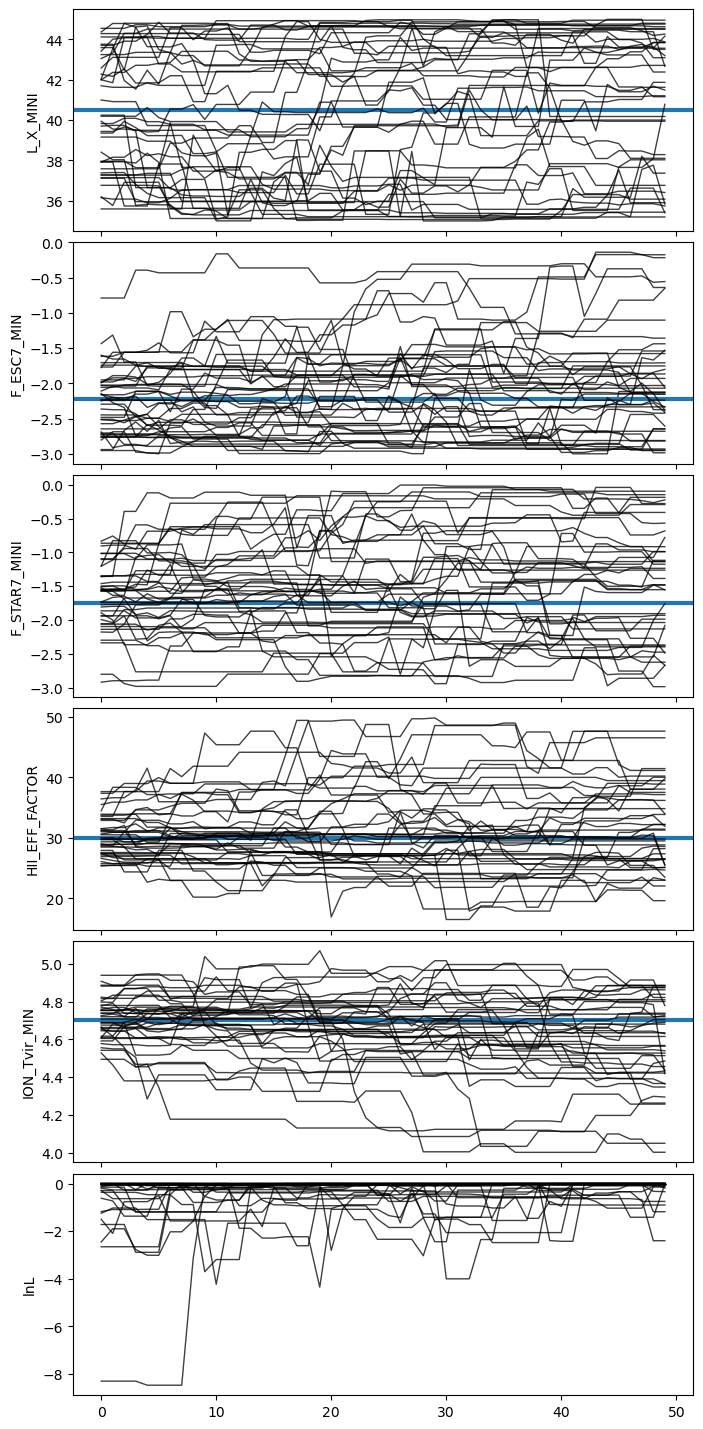

In [55]:
# Trace Plot
analyse.trace_plot(samples, include_lnl=True, start_iter=0, thin=1, colored=False, show_guess=True)
plt.savefig('Trace Plot_Likelihood_XHI(21cmFast).jpg', dpi=300, bbox_inches='tight')

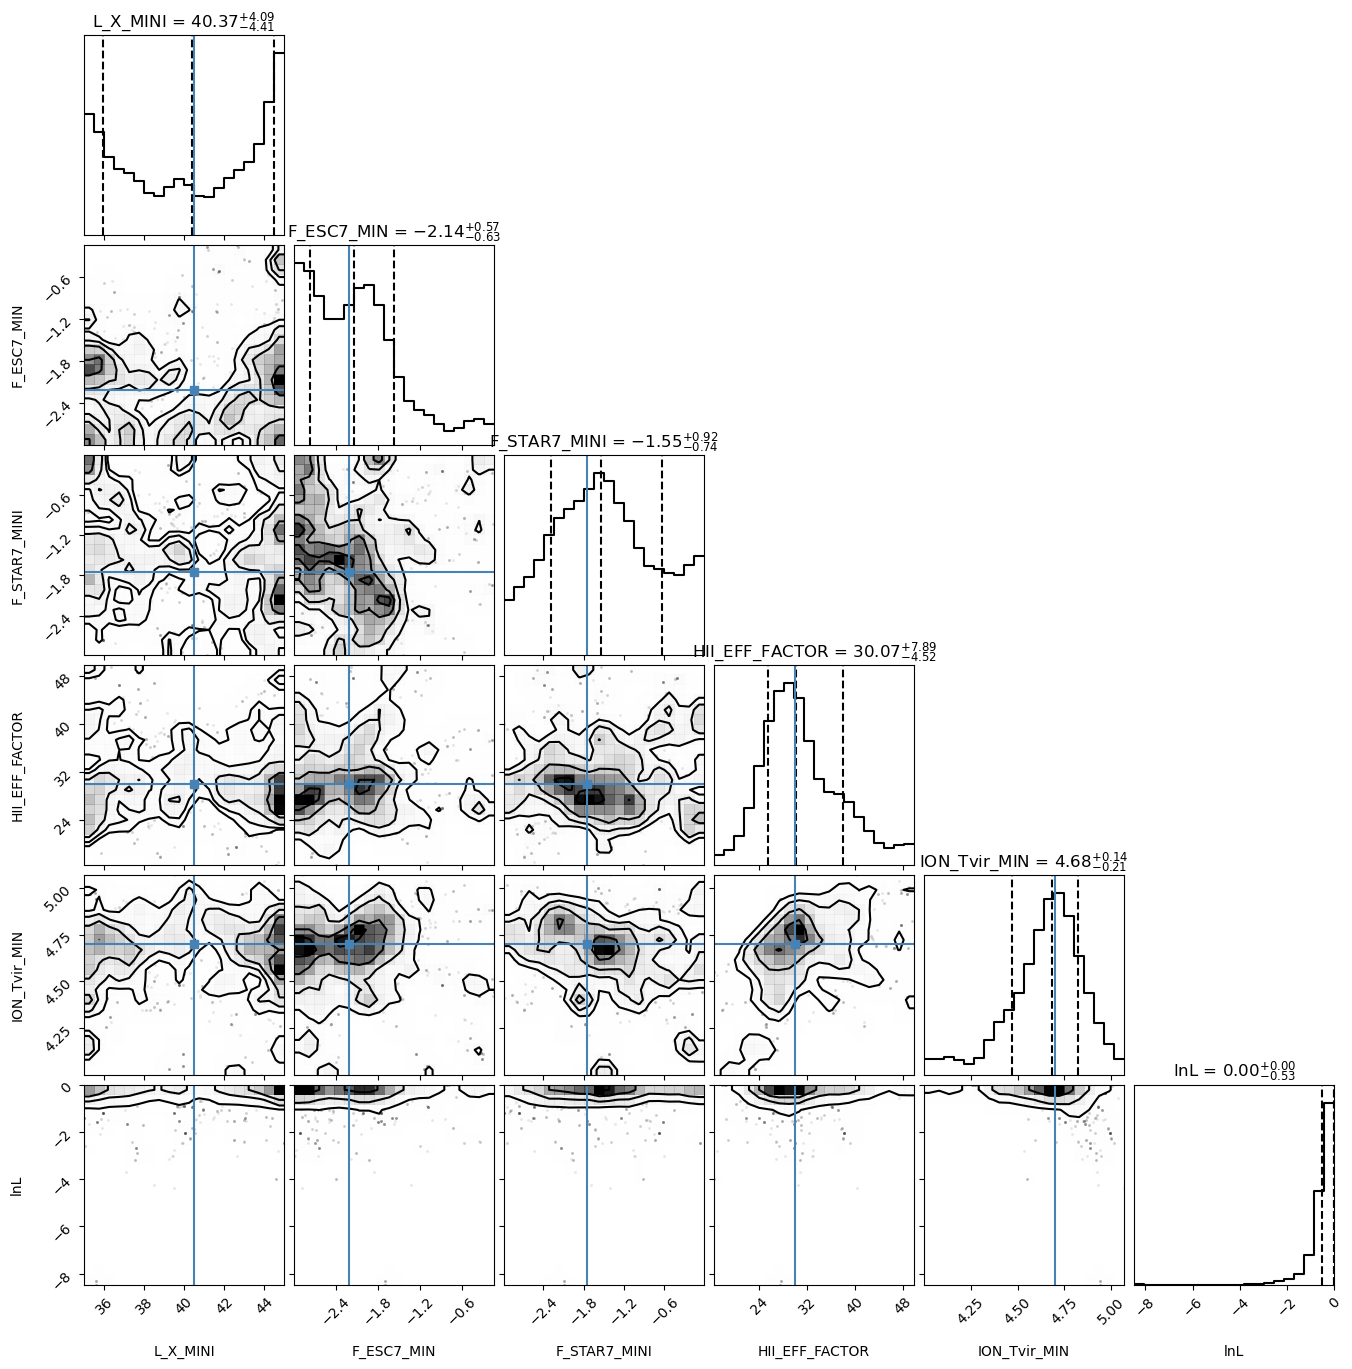

In [56]:
# Corner Plot
analyse.corner_plot(samples)
plt.savefig('corner Plot_Likelihood_XHI(21cmFast).jpg', dpi=300, bbox_inches='tight')